## Run Regression Model to create references for cell2location (late paed)

In [1]:
import sys 
import os
from datetime import datetime
date = datetime.now().strftime("%Y-%m-%d")
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import hdf5plugin

# Import key analysis packages
import cell2location
import scvi


# Define repo path and add it to sys path (allows to access scripts and metadata from repo)
repo_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/Spatial_analyses'
sys.path.insert(1, repo_path) 
sys.path.insert(2, '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts')


In [2]:
# Define paths for plot and path dirs
plot_path = os.path.join(repo_path, 'plots')
data_path = os.path.join(repo_path, 'data')
results_path = os.path.join(repo_path, 'results')
model_path = os.path.join(repo_path, 'models')
general_data_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/data'

In [3]:
# Set pandas display options
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

In [4]:
%load_ext autoreload
%autoreload 2
# Import custom scripts
from utils import get_latest_version,update_obs,freq_by_donor
from anno_levels import get_ct_levels, get_ct_palette, age_group_levels, age_group_palette
#from plotting.utils import plot_grouped_boxplot, calc_figsize

In [5]:
# Set plot formatting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
from matplotlib import rcParams
font_manager.fontManager.addfont("/nfs/team205/ny1/ThymusSpatialAtlas/software/Arial.ttf")
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text

In [6]:
sc.settings.set_figure_params(dpi = 80, color_map = 'RdPu')
#plt.style.use('/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')

In [7]:
## Define cell2location specific paths
results_folder = f'{model_path}/ThyAgeing_Visium_c2l_references_2025-09-01'
if not (os.path.isdir(f"{results_folder}")):
    print("Creating directory")
    os.mkdir(f"{results_folder}")
# create paths and names to results folders for reference regression and cell2location models
# ref_run_name = f'{results_folder}/reference_signatures'

In [8]:
age_group = 'paed'

In [9]:
ref_run_name1 = f'{results_folder}/paed_early'
ref_run_name2 = f'{results_folder}/paed_late'
ref_run_name3 = f'{results_folder}/adult'

for path in [ref_run_name1, ref_run_name2, ref_run_name3]:
    if not (os.path.isdir(f"{path}")):
        print(f"Creating directory: {path}")
        os.mkdir(f"{path}")

## Load adata object

In [10]:
# Load adata
object_version = 'v5_2025-04-03'
adata = ad.read_h5ad(f'{general_data_path}/objects/rna/thyAgeing_all_scvi_{object_version}.zarr')
# Add final annotations to adata and remove non-annotated cells
ct_anno = pd.read_csv(f'{general_data_path}/objects/rna/thyAgeing_all_scvi_v4_2025-02-04_curatedAnno_v10.csv', index_col = 0)

for c in ct_anno.columns:
    if c in adata.obs.columns:
        adata.obs.drop(c, axis = 1, inplace = True)
adata.obs = adata.obs.join(ct_anno)

adata = adata[~adata.obs['taa_l5'].isnull(),].copy()
# Update metadata
latest_meta_path = get_latest_version(dir = f'{general_data_path}/metadata', file_prefix='Thymus_ageing_metadata')
latest_meta = pd.read_excel(latest_meta_path)

update_obs(adata, latest_meta, on = 'index')


Latest file: Thymus_ageing_metadata_v28_2025-03-13.xlsx
No columns specified to update. Automatically determining columns to update...
Updating columns: ['age', 'age_cont', 'age_group', 'age_group2', 'age_months', 'age_num', 'age_unit', 'chemistry_detail', 'chemistry_orig', 'chemistry_simple', 'cite', 'comment', 'donor', 'health_status', 'in_HTSA', 'library', 'library_bcr', 'library_tcr_ab', 'library_tcr_gd', 'origin_institute', 'path_bcr', 'path_cellbender_gex', 'path_cellranger_arc', 'path_raw_gex', 'path_tcr_ab', 'path_tcr_gd', 'public_data', 'research_no', 'sample', 'sex', 'sort', 'sort_type', 'starsolo_version', 'study', 'type']
On columns: index


In [11]:
# Add TEC priming annotations
pri_anno = pd.read_csv(f'/nfs/team205/vk8/projects/thymus_ageing_atlas/TEC_compartment/data/objects/thyAgeing_prianno_2025-02-28.csv', index_col=0)
adata.obs['pri_anno'] = pri_anno.reindex(adata.obs_names)['pri_anno'].copy()

In [12]:
## update levels (DC levels needed to be updated)
latest_anno_path = get_latest_version(dir = f'{general_data_path}/curated', file_prefix='thyAgeing_full_curatedAnno')
new_anno = pd.read_excel(latest_anno_path)

Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx


In [13]:
update_obs(adata, new_anno, on = 'taa_l5')

No columns specified to update. Automatically determining columns to update...
Updating columns: ['anno_status', 'qc_status', 'taa_l0', 'taa_l1', 'taa_l2', 'taa_l3', 'taa_l4']
On columns: taa_l5


In [14]:
adata.obs['taa_l5'].isnull().sum()

0

## Load marker genes list

In [14]:
## Load marker genes 
markers_df = pd.read_csv(f'{data_path}/markers/thyAgeing_all_marker_genes_v1_2025-09-01.csv')
mrkrs_lst = markers_df['marker_gene'].unique().tolist()
len(mrkrs_lst)
mrkrs_lst.remove('TRB_nonprod')
mrkrs_lst.remove( 'TRB_recomb')
import math
# Remove nan values from mrkrs_lst if present
mrkrs_lst = [gene for gene in mrkrs_lst if gene is not None and not (isinstance(gene, float) and math.isnan(gene))]

442

## Clean adata for mapping, Cell selection

In [15]:
exclude_auto = list(set(adata.obs.loc[adata.obs['anno_status'] == 'explore', 'taa_l5'].unique().tolist() + adata.obs.loc[adata.obs['qc_status'] == 'FAIL', 'taa_l5'].unique().tolist()))

In [16]:
exclude_manual = ['EC-peri', 'B_GC-like-locnt', 'DC-donor-sp','DC1-locnt', 'DC1-prolif',
                'DC1-prolif-locnt','aDC1-locnt', 'aDC2-locnt', 'aDC3-locnt']
np.setdiff1d(exclude_auto, exclude_manual)
np.setdiff1d(exclude_manual, exclude_auto)

array([], dtype='<U16')

array(['DC1-prolif'], dtype='<U16')

In [17]:
#adata_lpaed_ref = adata[(adata.obs['age_group'] == 'infant') & (~adata.obs['taa_l5'].isin(exclude_manual)),].copy()
adata_lpaed_ref = adata[(adata.obs['age_group'] == 'paed') & (~adata.obs['taa_l5'].isin(exclude_manual)),].copy()
#adata_adult_ref = adata[(adata.obs['age_group'] == 'adult') & (~adata.obs['taa_l5'].isin(exclude_manual)),].copy()

In [18]:
def cell_selection_c2l(adata_input, cluster_key, ctype_ssample=10000, remove_groups= True, less_than=20, seed = 40): 
    print(f'Initial number of cells: {adata_input.shape[0]}')
    adata_input.obs['c2l_sel'] = False
    if ctype_ssample:
        cell_list = []
        for ctype in adata_input.obs[cluster_key].unique():
            adata_ctype = adata_input[adata_input.obs[cluster_key] == ctype,].copy()
            if ctype_ssample < adata_ctype.shape[0]:
                sc.pp.subsample(adata_ctype, n_obs = ctype_ssample, random_state=seed)
            cell_list.extend(adata_ctype.obs_names.tolist())
        adata_input.obs.loc[adata_input.obs_names.isin(cell_list), 'c2l_sel'] = True
        print(f'Number of cells after subsampling: {adata_input.obs["c2l_sel"].sum()}')
    if remove_groups:
        groups2remove = adata_input.obs[cluster_key].value_counts().loc[(adata_input.obs[cluster_key].value_counts()<less_than)].index.tolist()
        print(groups2remove)
        adata_input.obs.loc[adata_input.obs[cluster_key].isin(groups2remove), 'c2l_sel'] = False
        print(f'Number of cells after removing small groups:{adata_input.obs["c2l_sel"].sum()}')

In [19]:
cell_selection_c2l(adata_input = adata_lpaed_ref, cluster_key = 'taa_l4',ctype_ssample=10000, remove_groups= True, less_than=15)

Initial number of cells: 174180
Number of cells after subsampling: 103086
['aDC1', 'Neutrophil', 'EC-cap_lipid', 'Myelocyte', 'SMC-ven', 'B_dev', 'Mac_SPP1']
Number of cells after removing small groups:103055


## Gene selection

In [20]:
from cell2location.utils.filtering import filter_genes
def gene_selection_c2l (adata_input, keep_lst = None, cell_count_cutoff = 20, cell_percentage_cutoff2=0.05, nonz_mean_cutoff=1.2,
                    exclude_cc_genes=True, exclude_mt_genes=True, exclude_vdjgenes=True):
    
    adata_input.var['c2l_sel'] = False
    adata = adata_input[adata_input.obs['c2l_sel'],].copy()
   # adata = adata_input.copy()
    selected = filter_genes(adata, cell_count_cutoff, cell_percentage_cutoff2, nonz_mean_cutoff).tolist()
    selected = list(np.union1d(selected, keep_lst)) if keep_lst is not None else selected
    print(f'Marker genes which were removed by gene filtering: {list(np.setdiff1d(keep_lst, selected))}')
    selected_prefilter = selected.copy()
    if exclude_cc_genes:
        cell_cycle_genes = [x.strip() for x in open('/nfs/team205/vk8/processed_data/regev_lab_cell_cycle_genes.txt')]
        [selected.remove(i) for i in cell_cycle_genes if i in selected]
    if exclude_mt_genes:
        mt_genes = adata.var_names[adata.var_names.str.startswith('MT-')]
        [selected.remove(i) for i in mt_genes if i in selected]
    if exclude_vdjgenes:
        import re
        [selected.remove(i) for i in selected if re.search('^TR[AB][VDJ]|^IG[HKL][VDJC]', i)]
    print(f'Removed excluded genes:{np.setdiff1d(selected_prefilter, selected)}')
    print(f'Removed {len(np.setdiff1d(selected_prefilter, selected))} genes in total')
    # Select highly variable genes
    adata_input.var.loc[adata_input.var_names.isin(selected), 'c2l_sel'] = True
    print(f'Selected {adata.var["c2l_sel"].sum()} genes for model training')

/nfs/team205/vk8/mambaforge/envs/c2l_env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


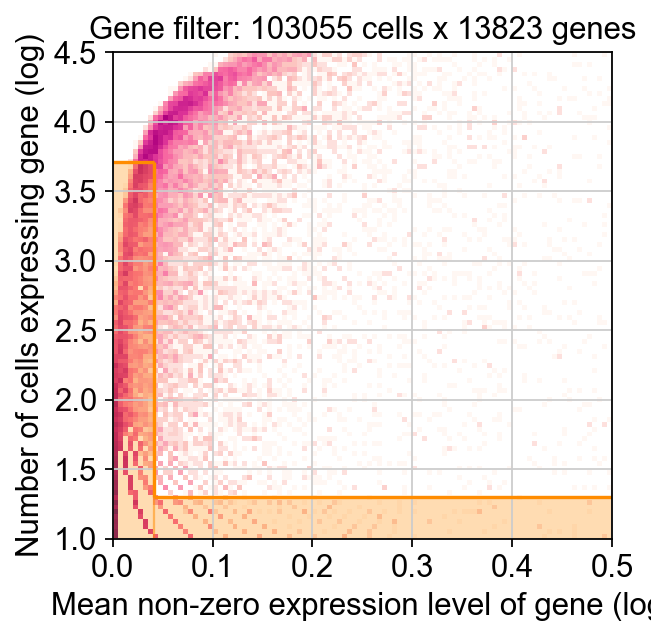

Marker genes which were removed by gene filtering: []
Removed excluded genes:['ANLN' 'ANP32E' 'ATAD2' 'AURKA' 'AURKB' 'BIRC5' 'BLM' 'BRIP1' 'BUB1'
 'CASP8AP2' 'CBX5' 'CCNB2' 'CCNE2' 'CDC20' 'CDC25C' 'CDC45' 'CDC6' 'CDCA2'
 'CDCA3' 'CDCA7' 'CDCA8' 'CDK1' 'CENPA' 'CENPE' 'CENPF' 'CHAF1B' 'CKAP2'
 'CKAP2L' 'CKAP5' 'CKS1B' 'CKS2' 'CLSPN' 'CTCF' 'DLGAP5' 'DSCC1' 'DTL'
 'E2F8' 'ECT2' 'EXO1' 'FEN1' 'G2E3' 'GAS2L3' 'GINS2' 'GMNN' 'GTSE1'
 'HELLS' 'HJURP' 'HMGB2' 'HMMR' 'IGHD' 'IGHV1-17' 'IGHV1-2' 'IGHV1-3'
 'IGHV1-46' 'IGHV1-69' 'IGHV1-69D' 'IGHV2-5' 'IGHV2-70D' 'IGHV3-13'
 'IGHV3-20' 'IGHV3-22' 'IGHV3-30' 'IGHV3-33' 'IGHV3-48' 'IGHV3-52'
 'IGHV3-64' 'IGHV3-65' 'IGHV3-7' 'IGHV3-74' 'IGHV4-31' 'IGHV4-39'
 'IGHV4-55' 'IGHV4-61' 'IGHV5-51' 'IGHV6-1' 'IGHV7-4-1' 'IGKC' 'IGKV1-16'
 'IGKV1-27' 'IGKV1-5' 'IGKV1-8' 'IGKV1D-33' 'IGKV1D-8' 'IGKV2-29'
 'IGKV2D-28' 'IGKV3-11' 'IGKV3-20' 'IGKV4-1' 'IGLC1' 'IGLC3' 'IGLC7'
 'IGLV1-40' 'IGLV1-47' 'IGLV2-11' 'IGLV2-23' 'IGLV3-1' 'IGLV3-19'
 'IGLV3-25' 'IGLV4-6

In [21]:
gene_selection_c2l(adata_input = adata_lpaed_ref, keep_lst = mrkrs_lst, cell_count_cutoff = 20, 
                   cell_percentage_cutoff2=0.05, nonz_mean_cutoff=1.1, exclude_cc_genes=True, exclude_mt_genes=True, exclude_vdjgenes=True)

## Estimation of reference cell type signatures (NB regression) <a class="anchor" id="Estimating_signatures"></a>

The signatures are estimated from scRNA-seq data, accounting for batch effect, using a Negative binomial regression model.

In [22]:
adata_lpaed_ref = adata_lpaed_ref[adata_lpaed_ref.obs['c2l_sel'], adata_lpaed_ref.var['c2l_sel']].copy()
adata_lpaed_ref.shape

(103055, 13632)

In [23]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_lpaed_ref, 
                        # 10X reaction / sample / batch
                        batch_key='sample', 
                        # cell type, covariate used for constructing signatures
                        labels_key='taa_l4', 
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['chemistry_simple', 'donor'])                       

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [24]:
# create and train the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_lpaed_ref) 
# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.2.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': 'taa_l4',
│   'categorical_covariate_keys': ['chemistry_simple', 'donor'],
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   30   │
│         n_cells          │ 103055 │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   76   │
│          n_vars          │ 13632  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                        batch State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃      Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │       TEC_112        │          0          │
│                     │       THY_112        │          1          │
│                     │        THY_57        │          2          │
│                     │        THY_90        │          3          │
│                     │        TTA11         │          4          │
│                     │        TTA12         │          5          │
│                     │    Z12-THY--SC-1     │          6          │
│                     │    Z12-THY--SC-2     │          7          │
│                     │  Z12-THY--SC-45N-1   │          8          │
│                     │  Z12-THY--SC-EPCP-1  │          9          │
│                     │  Z12-THY--SC-EPCP-2  │         10          │
│                     │    Z13-THY--SC-1     │         11          │
│                     │    Z13-THY--SC-2     │         12          │
│                     │  Z13-THY--SC-45N-1   │         13          │
│                     │  Z13-THY--SC-EPCP-1  │         14          │
│                     │    Z15-THY-0-SC-1    │         15          │
│                     │  Z15-THY-0-SC-45N-1  │         16          │
│                     │  Z15-THY-0-SC-45N-2  │         17          │
│                     │ Z15-THY-0-SC-EPCP-1  │         18          │
│                     │    Z16-THY-0-SC-1    │         19          │
│                     │    Z16-THY-0-SC-2    │         20          │
│                     │  Z16-THY-0-SC-45N-1  │         21          │
│                     │    Z17-THY-0-SC-1    │         22          │
│                     │    Z17-THY-0-SC-2    │         23          │
│                     │  Z17-THY-0-SC-45N-1  │         24          │
│                     │  Z17-THY-0-SC-45N-2  │         25          │
│                     │ Z17-THY-0-SC-EPCP-1  │         26          │
│                     │    Z19-THY-0-SC-1    │         27          │
│                     │ Z19-THY-0-SC-EPCP-1  │         28          │
│                     │ Z19-THY-0-SC-F-45N-1 │         29          │
└─────────────────────┴──────────────────────┴─────────────────────┘

                      labels State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃     Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['taa_l4'] │     B_GC-like      │          0          │
│                     │  B_age-associated  │          1          │
│                     │     B_dev_thy      │          2          │
│                     │       B_mem        │          3          │
│                     │      B_naive       │          4          │
│                     │      B_plasma      │          5          │
│                     │   B_plasmablast    │          6          │
│                     │        CMP         │          7          │
│                     │        DC1         │          8          │
│                     │        DC2         │          9          │
│                     │     DC2_SFTPD      │         10          │
│                     │       EC-art       │         11          │
│                     │       EC-cap       │         12          │
│                     │    EC-lymphatic    │         13          │
│                     │       EC-ven       │         14          │
│                     │      Fb-adipo      │         15          │
│                     │     Fb-interlo     │         16          │
│                     │  Fb-interlo_PI16   │         17          │
│                     │     Fb-interm      │         18          │
│                     │       Fb-med       │         19          │
│                     │     Fb-perilo      │         20          │
│                     │ Fb-perilo_COLEC11  │         21          │
│                     │        ILC         │         22          │
│                     │        Mac         │         23          │
│                     │     Mac_LYVE1      │         24          │
│                     │      Mac_SPIC      │         25          │
│                     │        Mast        │         26          │
│                     │        Mono        │         27          │
│                     │       NK_tr        │         28          │
│                     │      Peri-cap      │         29          │
│                     │  Peri-smc-interm   │         30          │
│                     │    Promonocyte     │         31          │
│                     │      SMC-art       │         32          │
│                     │      TEC-EMT       │         33          │
│                     │   TEC-cilliated    │         34          │
│                     │      TEC-iono      │         35          │
│                     │      TEC-myo       │         36          │
│                     │     TEC-neuro      │         37          │
│                     │      TEC-tuft      │         38          │
│                     │     T_CD4_act      │         39          │
│                     │      T_CD4_fh      │         40          │
│                     │      T_CD4_h       │         41          │
│                     │    T_CD4_naive     │         42          │
│                     │ T_CD4_naive_recirc │         43          │
│                     │  T_CD8_age-assoc   │         44          │
│                     │      T_CD8_em      │         45          │
│                     │    T_CD8_naive     │         46          │
│                     │ T_CD8_naive_recirc │         47          │
│                     │      T_CD8_rm      │         48          │
│                     │     T_CD8αα(I)     │         49          │
│                     │    T_CD8αα(II)     │         50          │
│                     │   T_CD8αα(entry)   │         51          │
│                     │      T_DN(P)       │         52          │
│                     │      T_DN(Q)       │         53          │
│                     │    T_DN(early)     │         54          │
│                     │     T_DN(late)     │   

               extra_categorical_covs State Registry                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['chemistry_simple'] │    3GEX    │          0          │
│                               │    5GEX    │          1          │
│                               │            │                     │
│      adata.obs['donor']       │ NIHTHY0057 │          0          │
│                               │ NIHTHY0090 │          1          │
│                               │ NIHTHY0112 │          2          │
│                               │     P2     │          3          │
│                               │    Z12     │          4          │
│                               │    Z13     │          5          │
│                               │    Z15     │          6          │
│                               │    Z16     │          7          │
│                               │    Z17     │          8          │
│                               │    Z19     │          9          │
│                               │            │                     │
└───────────────────────────────┴────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/vk8/mambaforge/envs/c2l_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team205/vk8/mambaforge/envs/c2l_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the val

Epoch 250/250: 100%|████████| 250/250 [21:37<00:00,  5.39s/it, v_num=1, elbo_train=4.73e+8]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|████████| 250/250 [21:37<00:00,  5.19s/it, v_num=1, elbo_train=4.73e+8]


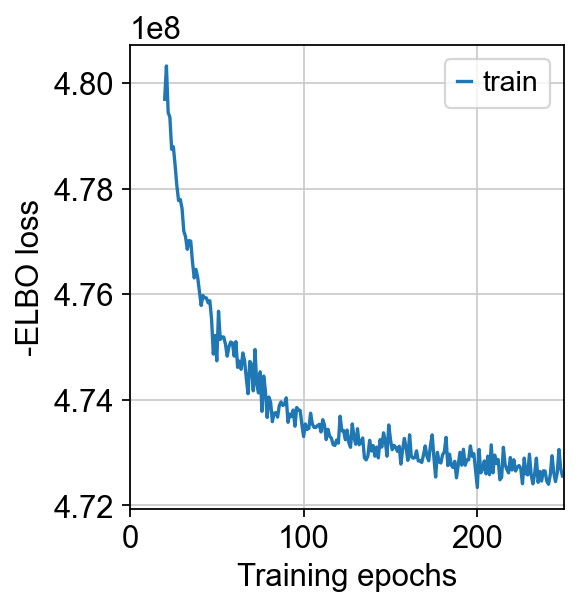

In [25]:
# Use all data for training (validation not implemented yet, train_size=1)
mod.train(max_epochs=250, batch_size=2500, train_size=1, lr=0.002)# use_gpu=True)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(20)

In [26]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_lpaed_ref = mod.export_posterior(
    adata_lpaed_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500}
)

# Save model
mod.save(f"{ref_run_name2}", overwrite=True)

Sampling global variables, sample: 100%|████████████████| 999/999 [00:09<00:00, 104.87it/s]


In [27]:
for col in adata_lpaed_ref.obs.columns:
    if (adata_lpaed_ref.obs[col].dtype == 'object') | (adata_lpaed_ref.obs[col].dtype == 'category'):
        adata_lpaed_ref.obs[col] = adata_lpaed_ref.obs[col].astype(str) 

In [28]:
# Save anndata object with results
adata_lpaed_file = f"{ref_run_name2}/sc.h5ad"
adata_lpaed_ref.write_h5ad(adata_lpaed_file, 
                       compression=hdf5plugin.FILTERS["zstd"],
        compression_opts=hdf5plugin.Zstd(clevel=5).filter_options)
adata_lpaed_file

'/nfs/team205/vk8/projects/thymus_ageing_atlas/Spatial_analyses/models/ThyAgeing_Visium_c2l_references_2025-09-01/paed_late/sc.h5ad'

#read in results of regression model (if notebook is reloaded)
adata_ref = sc.read("/nfs/team205/vk8/scripts/visium/cell2location_v2/results/reference_signatures/sc.h5ad")
adata_vis = sc.read("/nfs/team205/vk8/scripts/visium/cell2location_v2/results/adata_vis_2021-10-01.h5ad")

In [ ]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,B_GC-like,B_age-associated,B_dev_thy,B_med,B_mem
LINC01128,0.071256,0.033316,0.102319,0.050983,0.023560
SAMD11,0.001159,0.000725,0.007989,0.002234,0.000614
NOC2L,0.502874,0.173373,0.303305,0.502522,0.175449
PLEKHN1,0.002700,0.001960,0.006348,0.003785,0.000955
HES4,0.083597,0.049751,1.822241,0.139217,0.013250
